In [3]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
import cftime

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = '/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/'
out_path_data = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data/'

In [4]:
ds = xr.open_dataset('/work/Katherine.Turner/smaller_projects/hifreq-variability/data/CM4_cmip_monthly_storms.nc', use_cftime=True)

In [5]:
storms_seasonal = ds.center_counts.resample(time='QS-DEC').sum()

In [6]:
idx_jja = storms_seasonal.time.dt.month == 6
idx_djf = storms_seasonal.time.dt.month == 12

## Finding high-storm and low-storm years

In [7]:
storms_djf = storms_seasonal[idx_djf][1:-1]
storms_jja = storms_seasonal[idx_jja]

In [8]:
lo_djf = storms_djf.sortby(storms_djf).time[:50]
hi_djf = storms_djf.sortby(storms_djf).time[-50:]

idx_hi_djf = storms_djf.time.isin(hi_djf)
idx_lo_djf = storms_djf.time.isin(lo_djf)

storms_djf[idx_hi_djf].mean(), storms_djf[idx_lo_djf].mean()

(<xarray.DataArray 'center_counts' ()>
 array(2318.46),
 <xarray.DataArray 'center_counts' ()>
 array(1861.68))

In [9]:
lo_jja = storms_jja.sortby(storms_jja).time[:50]
hi_jja = storms_jja.sortby(storms_jja).time[-50:]

idx_hi_jja = storms_jja.time.isin(hi_jja)
idx_lo_jja = storms_jja.time.isin(lo_jja)

storms_jja[idx_hi_jja].mean(), storms_jja[idx_lo_jja].mean()

(<xarray.DataArray 'center_counts' ()>
 array(2704.38),
 <xarray.DataArray 'center_counts' ()>
 array(2205.96))

# Creating composites for atmosphere/ocean/sea ice conditions

## 1. Atmospheric conditions

In [23]:
var = 'slp'
ds_v = xr.open_mfdataset(f'/work/Katherine.Turner/tempest-extremes/CM4_cmip/data/*{var}.nc', use_cftime=True)

midx_djf = ds_v.time.dt.month.isin([1,2,12])
midx_jja = ds_v.time.dt.month.isin([6,7,8])

midx_hi_djf = (ds_v.time.dt.year.isin(hi_djf.dt.year) & ds_v.time.dt.month.isin([12])) | (ds_v.time.dt.year.isin(hi_djf.dt.year+1) & ds_v.time.dt.month.isin([1,2])) 
midx_lo_djf = (ds_v.time.dt.year.isin(lo_djf.dt.year) & ds_v.time.dt.month.isin([12])) | (ds_v.time.dt.year.isin(lo_djf.dt.year+1) & ds_v.time.dt.month.isin([1,2]))

midx_hi_jja = (ds_v.time.dt.year.isin(hi_jja.dt.year) & ds_v.time.dt.month.isin([6,7,8])) 
midx_lo_jja = (ds_v.time.dt.year.isin(lo_jja.dt.year) & ds_v.time.dt.month.isin([6,7,8])) 

mean_djf = ds_v[var][midx_djf,:,:].mean(dim='time').compute()
std_djf = ds_v[var][midx_djf,:,:].std(dim='time').compute()

mean_jja = ds_v[var][midx_jja,:,:].mean(dim='time').compute()
std_jja = ds_v[var][midx_jja,:,:].std(dim='time').compute()

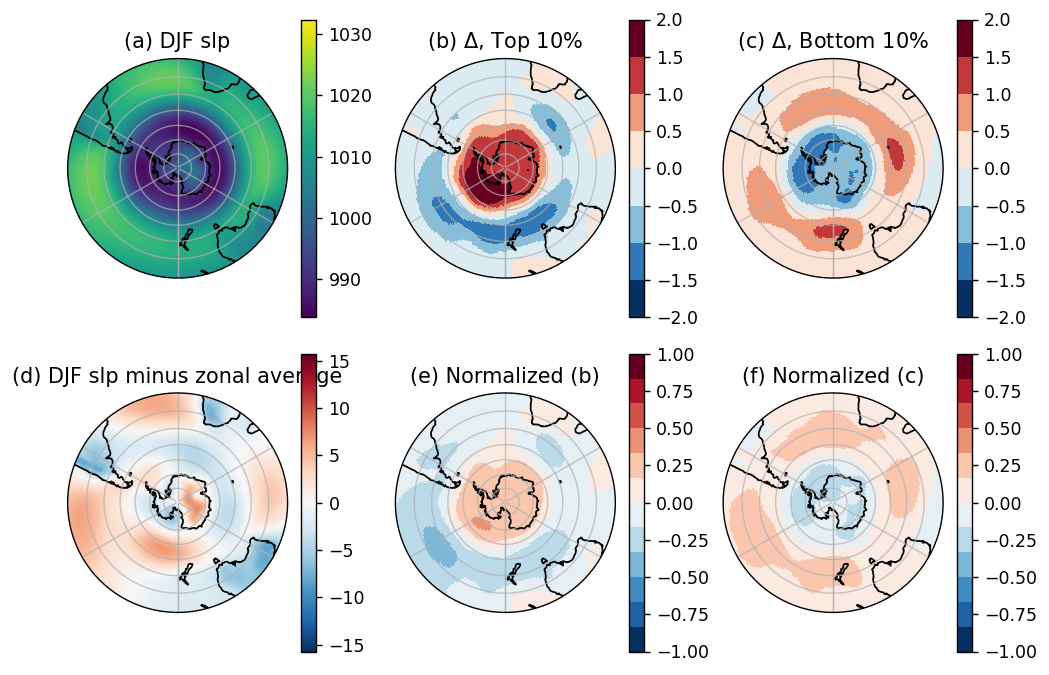

In [33]:
## Summer month composites

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()



mean_djf.plot(ax=axs[0],
            x='lon', y='lat',
            transform=ccrs.PlateCarree(),
            #vmax=18, extend='neither',
            #cmap=plt.get_cmap('viridis', 12),
            cbar_kwargs={'label':''},
           )

axs[0].set_title('(a) DJF slp')

## now including variations from zonal means

(mean_djf - mean_djf.mean(dim='lon')).plot(ax=axs[3],
                                           x='lon', y='lat',
                                           transform=ccrs.PlateCarree(),
                                           #vmax=1020, extend='neither',
                                           #cmap=plt.get_cmap('viridis', 12),
                                           cbar_kwargs={'label':''},
                                          )
axs[3].set_title('(d) DJF slp minus zonal average')
                                                                                                              

(ds_v[var][midx_hi_djf,:,:].mean(dim='time') - mean_djf).plot(ax=axs[1],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-2, vmax=2, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[1].set_title('(b) $\Delta$, Top 10%')

(ds_v[var][midx_lo_djf,:,:].mean(dim='time') - mean_djf).plot(ax=axs[2],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-2, vmax=2, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[2].set_title('(c) $\Delta$, Bottom 10%')
                                                            

((ds_v[var][midx_hi_djf,:,:].mean(dim='time') - mean_djf)/std_djf).plot(ax=axs[4],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[4].set_title('(e) Normalized (b)')

((ds_v[var][midx_lo_djf,:,:].mean(dim='time') - mean_djf)/std_djf).plot(ax=axs[5],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[5].set_title('(f) Normalized (c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -20], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
#axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)

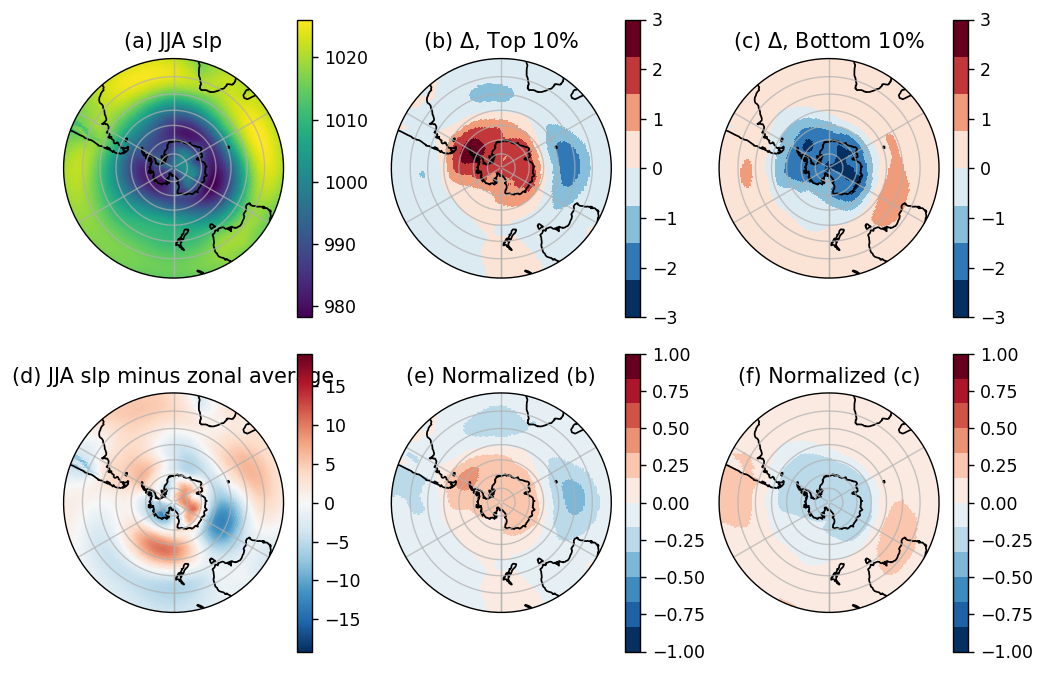

In [34]:
## Winter month composites

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()



mean_jja.plot(ax=axs[0],
            x='lon', y='lat',
            transform=ccrs.PlateCarree(),
            #vmax=18, extend='neither',
            #cmap=plt.get_cmap('viridis', 12),
            cbar_kwargs={'label':''},
           )

axs[0].set_title('(a) JJA slp')

## now including variations from zonal means

(mean_jja - mean_jja.mean(dim='lon')).plot(ax=axs[3],
                                           x='lon', y='lat',
                                           transform=ccrs.PlateCarree(),
                                           #vmax=1020, extend='neither',
                                           #cmap=plt.get_cmap('viridis', 12),
                                           cbar_kwargs={'label':''},
                                          )

axs[3].set_title('(d) JJA slp minus zonal average')
                                                                                                              

(ds_v[var][midx_hi_jja,:,:].mean(dim='time') - mean_jja).plot(ax=axs[1],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-3, vmax=3, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[1].set_title('(b) $\Delta$, Top 10%')

(ds_v[var][midx_lo_jja,:,:].mean(dim='time') - mean_jja).plot(ax=axs[2],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-3, vmax=3, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[2].set_title('(c) $\Delta$, Bottom 10%')
                                                            

((ds_v[var][midx_hi_jja,:,:].mean(dim='time') - mean_jja)/std_jja).plot(ax=axs[4],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[4].set_title('(e) Normalized (b)')

((ds_v[var][midx_lo_jja,:,:].mean(dim='time') - mean_jja)/std_jja).plot(ax=axs[5],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[5].set_title('(f) Normalized (c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -20], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
#axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_jja_CM4-500.png", format='png', dpi=100)

## 2. Ocean conditions

In [35]:
var = 'tos'
ds_v = xr.open_mfdataset(f'/work/Katherine.Turner/tempest-extremes/CM4_cmip/data/*{var}.nc', use_cftime=True)

midx_djf = ds_v.time.dt.month.isin([1,2,12])
midx_jja = ds_v.time.dt.month.isin([6,7,8])

midx_hi_djf = (ds_v.time.dt.year.isin(hi_djf.dt.year) & ds_v.time.dt.month.isin([12])) | (ds_v.time.dt.year.isin(hi_djf.dt.year+1) & ds_v.time.dt.month.isin([1,2])) 
midx_lo_djf = (ds_v.time.dt.year.isin(lo_djf.dt.year) & ds_v.time.dt.month.isin([12])) | (ds_v.time.dt.year.isin(lo_djf.dt.year+1) & ds_v.time.dt.month.isin([1,2]))

midx_hi_jja = (ds_v.time.dt.year.isin(hi_jja.dt.year) & ds_v.time.dt.month.isin([6,7,8])) 
midx_lo_jja = (ds_v.time.dt.year.isin(lo_jja.dt.year) & ds_v.time.dt.month.isin([6,7,8])) 

mean_djf = ds_v[var][midx_djf,:,:].mean(dim='time').compute()
std_djf = ds_v[var][midx_djf,:,:].std(dim='time').compute()

mean_jja = ds_v[var][midx_jja,:,:].mean(dim='time').compute()
std_jja = ds_v[var][midx_jja,:,:].std(dim='time').compute()

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


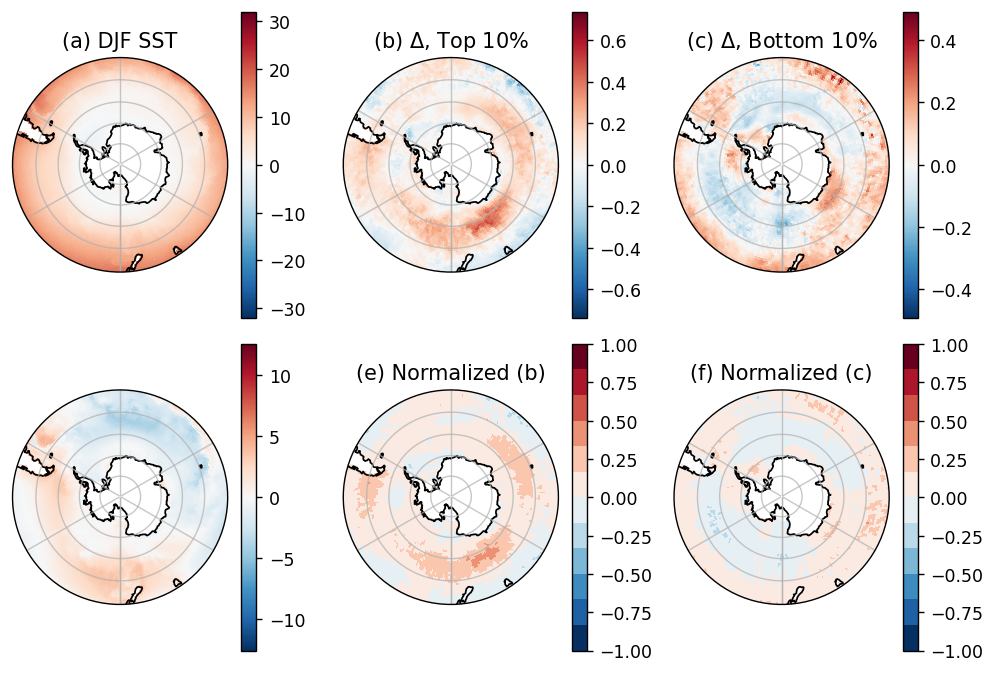

In [39]:
## Summer month composites

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()



mean_djf.plot(ax=axs[0],
            x='lon', y='lat',
            transform=ccrs.PlateCarree(),
            #vmax=18, extend='neither',
            #cmap=plt.get_cmap('viridis', 12),
            cbar_kwargs={'label':''},
           )

axs[0].set_title('(a) DJF SST')

## now including variations from zonal means

(mean_djf - mean_djf.mean(dim='lon')).plot(ax=axs[3],
                                            x='lon', y='lat',
                                            transform=ccrs.PlateCarree(),
                                            #vmax=1020, extend='neither',
                                            #cmap=plt.get_cmap('viridis', 12),
                                            cbar_kwargs={'label':''},
                                           )
# axs[3].set_title('(d) DJF SST minus zonal average')
                                                                                                              

(ds_v[var][midx_hi_djf,:,:].mean(dim='time') - mean_djf).plot(ax=axs[1],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmin=-2, vmax=2, extend='neither',
                                                   #cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[1].set_title('(b) $\Delta$, Top 10%')

(ds_v[var][midx_lo_djf,:,:].mean(dim='time') - mean_djf).plot(ax=axs[2],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmin=-2, vmax=2, extend='neither',
                                                   #cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[2].set_title('(c) $\Delta$, Bottom 10%')
                                                            

((ds_v[var][midx_hi_djf,:,:].mean(dim='time') - mean_djf)/std_djf).plot(ax=axs[4],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[4].set_title('(e) Normalized (b)')

((ds_v[var][midx_lo_djf,:,:].mean(dim='time') - mean_djf)/std_djf).plot(ax=axs[5],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[5].set_title('(f) Normalized (c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
#axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)

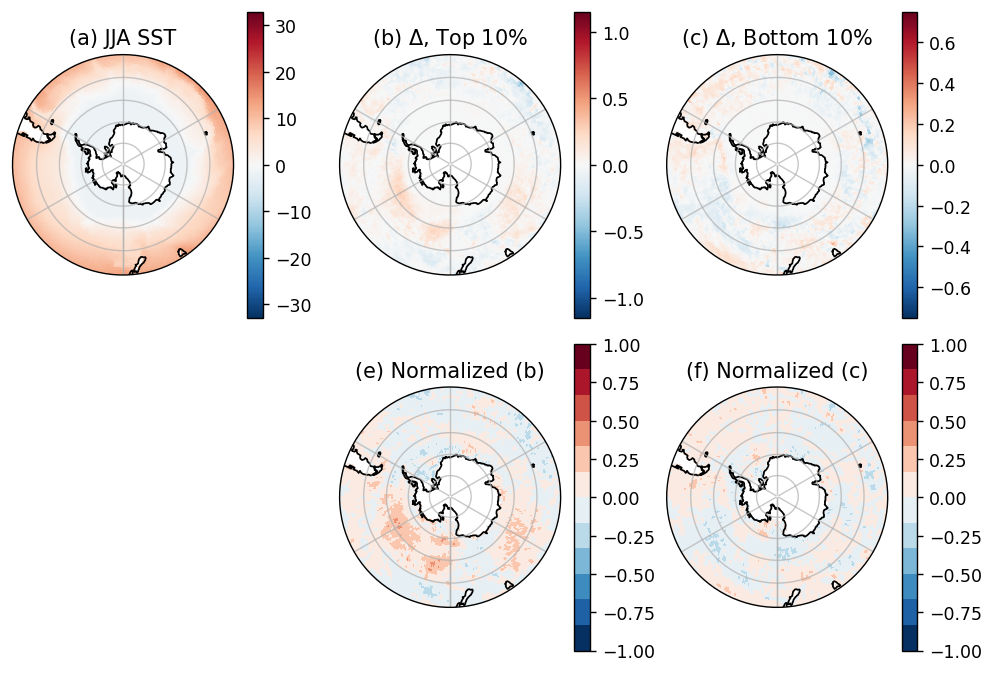

In [40]:
## Winter month composites

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()



mean_jja.plot(ax=axs[0],
            x='lon', y='lat',
            transform=ccrs.PlateCarree(),
            #vmax=18, extend='neither',
            #cmap=plt.get_cmap('viridis', 12),
            cbar_kwargs={'label':''},
           )

axs[0].set_title('(a) JJA SST')

## now including variations from zonal means

# (mean_jja - mean_jja.mean(dim='lon')).plot(ax=axs[3],
#                                            x='lon', y='lat',
#                                            transform=ccrs.PlateCarree(),
#                                            #vmax=1020, extend='neither',
#                                            #cmap=plt.get_cmap('viridis', 12),
#                                            cbar_kwargs={'label':''},
#                                           )
# axs[3].set_title('(d) DJF SST minus zonal average')
                                                                                                              

(ds_v[var][midx_hi_jja,:,:].mean(dim='time') - mean_jja).plot(ax=axs[1],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmin=-2, vmax=2, extend='neither',
                                                   #cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[1].set_title('(b) $\Delta$, Top 10%')

(ds_v[var][midx_lo_jja,:,:].mean(dim='time') - mean_jja).plot(ax=axs[2],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmin=-2, vmax=2, extend='neither',
                                                   #cmap=plt.get_cmap('RdBu_r', 8),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[2].set_title('(c) $\Delta$, Bottom 10%')
                                                            

((ds_v[var][midx_hi_jja,:,:].mean(dim='time') - mean_jja)/std_jja).plot(ax=axs[4],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[4].set_title('(e) Normalized (b)')

((ds_v[var][midx_lo_jja,:,:].mean(dim='time') - mean_jja)/std_jja).plot(ax=axs[5],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[5].set_title('(f) Normalized (c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_jja_CM4-500.png", format='png', dpi=100)

## 3. Sea Ice conditions

In [20]:
ds_v = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/CM4_cmip/data/*siconc.nc', use_cftime=True)

midx_djf = ds_v.time.dt.month.isin([1,2,12])
midx_jja = ds_v.time.dt.month.isin([6,7,8])

midx_hi_djf = (ds_v.time.dt.year.isin(hi_djf.dt.year) & ds_v.time.dt.month.isin([12])) | (ds_v.time.dt.year.isin(hi_djf.dt.year+1) & ds_v.time.dt.month.isin([1,2])) 
midx_lo_djf = (ds_v.time.dt.year.isin(lo_djf.dt.year) & ds_v.time.dt.month.isin([12])) | (ds_v.time.dt.year.isin(lo_djf.dt.year+1) & ds_v.time.dt.month.isin([1,2]))

midx_hi_jja = (ds_v.time.dt.year.isin(hi_jja.dt.year) & ds_v.time.dt.month.isin([6,7,8])) 
midx_lo_jja = (ds_v.time.dt.year.isin(lo_jja.dt.year) & ds_v.time.dt.month.isin([6,7,8])) 

siconc_djf = ds_v.siconc[midx_djf,:,:].mean(dim='time').compute()
siconc_djf_std = ds_v.siconc[midx_djf,:,:].std(dim='time').compute()

siconc_jja = ds_v.siconc[midx_jja,:,:].mean(dim='time').compute()
siconc_jja_std = ds_v.siconc[midx_jja,:,:].std(dim='time').compute()

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


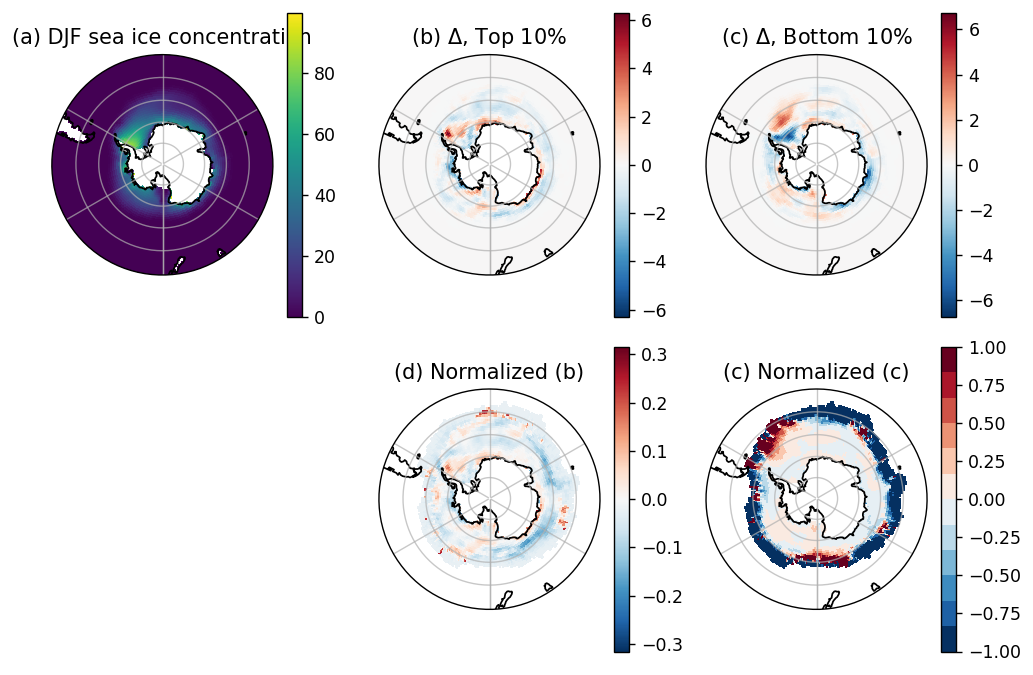

In [19]:
## Summer month composites

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()



siconc_djf.plot(ax=axs[0],
            x='lon', y='lat',
            transform=ccrs.PlateCarree(),
            #vmax=18, extend='neither',
            #cmap=plt.get_cmap('viridis', 12),
            cbar_kwargs={'label':''},
           )

axs[0].set_title('(a) DJF sea ice concentration')

### now including variations from zonal means
#
#(ds_v.siconc_djf[midx_djf,:,:].mean(dim='time') - ds_v.siconc_djf[midx_djf,:,:].mean(dim='time').mean(dim='lon')).plot(ax=axs[3],
#                                                                                                               x='lon', y='lat',
#                                                                                                               transform=ccrs.PlateCarree(),
#                                                                                                               #vmax=18, extend='neither',
#                                                                                                               #cmap=plt.get_cmap('viridis', 12),
#                                                                                                               cbar_kwargs={'label':''},
#                                                                                                              )
                                                                                                              

(ds_v.siconc[midx_hi_djf,:,:].mean(dim='time') - siconc_djf).plot(ax=axs[1],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmax=18, extend='neither',
                                                   #cmap=plt.get_cmap('viridis', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[1].set_title('(b) $\Delta$, Top 10%')

(ds_v.siconc[midx_lo_djf,:,:].mean(dim='time') - siconc_djf).plot(ax=axs[2],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmax=18, extend='neither',
                                                   #cmap=plt.get_cmap('viridis', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[2].set_title('(c) $\Delta$, Bottom 10%')
                                                            

((ds_v.siconc[midx_hi_djf,:,:].mean(dim='time') - siconc_djf)/siconc_djf_std).plot(ax=axs[4],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmax=18, extend='neither',
                                                   #cmap=plt.get_cmap('viridis', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[4].set_title('(d) Normalized (b)')

((ds_v.siconc[midx_lo_djf,:,:].mean(dim='time') - siconc_djf)/siconc_djf_std).plot(ax=axs[5],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[5].set_title('(c) Normalized (c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)

AttributeError: 'Dataset' object has no attribute 'siconc'

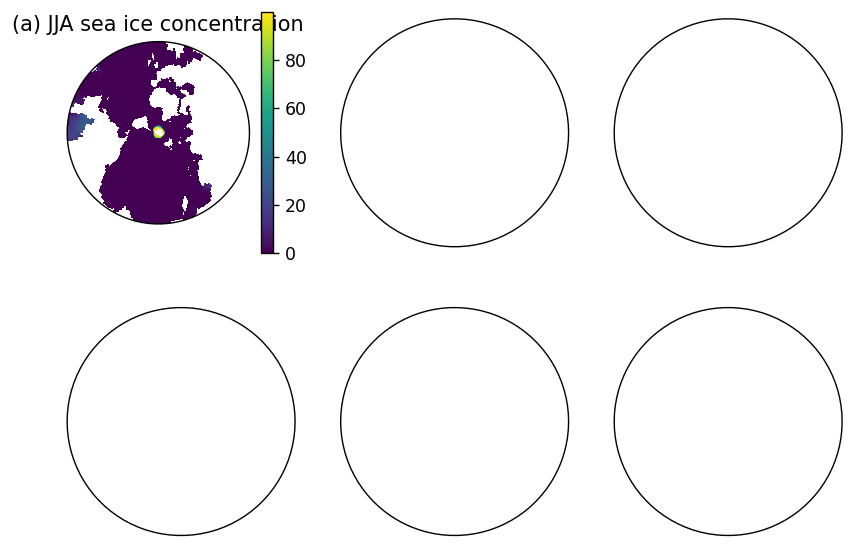

In [25]:
## Winter month composites

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()



siconc_jja.plot(ax=axs[0],
            x='lon', y='lat',
            transform=ccrs.PlateCarree(),
            #vmax=18, extend='neither',
            #cmap=plt.get_cmap('viridis', 12),
            cbar_kwargs={'label':''},
           )

axs[0].set_title('(a) JJA sea ice concentration')

### now including variations from zonal means
#
#(ds_v.siconc[midx_djf,:,:].mean(dim='time') - ds_v.siconc[midx_djf,:,:].mean(dim='time').mean(dim='lon')).plot(ax=axs[3],
#                                                                                                               x='lon', y='lat',
#                                                                                                               transform=ccrs.PlateCarree(),
#                                                                                                               #vmax=18, extend='neither',
#                                                                                                               #cmap=plt.get_cmap('viridis', 12),
#                                                                                                               cbar_kwargs={'label':''},
#                                                                                                              )
                                                                                                              

(ds_v.siconc[midx_hi_jja,:,:].mean(dim='time') - siconc_jja).plot(ax=axs[1],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmax=18, extend='neither',
                                                   #cmap=plt.get_cmap('viridis', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[1].set_title('(b) $\Delta$, Top 10%')

(ds_v.siconc[midx_lo_jja,:,:].mean(dim='time') - siconc_jja).plot(ax=axs[2],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmax=18, extend='neither',
                                                   #cmap=plt.get_cmap('viridis', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[2].set_title('(c) $\Delta$, Bottom 10%')
                                                            

((ds_v.siconc[midx_hi_jja,:,:].mean(dim='time') - siconc_jja)/siconc_jja_std).plot(ax=axs[4],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   #vmax=18, extend='neither',
                                                   #cmap=plt.get_cmap('viridis', 12),
                                                   cbar_kwargs={'label':''},
                                                  )
axs[4].set_title('(d) Normalized (b)')

((ds_v.siconc[midx_lo_jja,:,:].mean(dim='time') - siconc_jja)/siconc_jja_std).plot(ax=axs[5],
                                                   x='lon', y='lat',
                                                   transform=ccrs.PlateCarree(),
                                                   vmin=-1, vmax=1, extend='neither',
                                                   cmap=plt.get_cmap('RdBu_r', 12),
                                                   cbar_kwargs={'label':''},
                                                  )

axs[5].set_title('(c) Normalized (c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)